<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/vqvae_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE for clustering data

Based on 

https://arxiv.org/abs/1711.00937  
https://arxiv.org/abs/1906.00446

https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb



In [2]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

W0619 16:20:44.348990 140493551802240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0619 16:20:45.821802 140493551802240 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Create some data

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=7, n_features=50,random_state=0)
data_variance = np.var(X)

# Define Encoder & Decoder


In [0]:
class Encoder(snt.AbstractModule):
  def __init__(self, name='encoder'):
    super(Encoder, self).__init__(name=name)
    
  def _build(self, x):
    h = snt.Linear(32)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(16)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(10)(h)
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, output_dim, name='decoder'):
    super(Decoder, self).__init__(name=name)
    self.output_dim = output_dim
  
  def _build(self, x):
    h = snt.Linear(16)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(32)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(self.output_dim)(h)
    return h

# Build Graph and train

In [5]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 64

num_training_updates = 5000
embedding_dim = 10
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 20

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(X)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()

def get_samples(sess, subset='train'):
    return sess.run(train_dataset_batch)

# Build modules.
encoder = Encoder()
decoder = Decoder(X.shape[1])

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
z = encoder(x)

# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  feed_dict = {x: get_samples(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 100 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
    print()


W0619 16:21:03.257725 140493551802240 deprecation.py:323] From <ipython-input-5-629bb0a4307c>:33: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
W0619 16:21:03.299336 140493551802240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/modules/base.py:177: The name tf.make_template is deprecated. Please use tf.compat.v1.make_template instead.

W0619 16:21:03.319672 140493551802240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/modules/base.py:278: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 16:21:03.321041 140493551802240 dep

100 iterations
recon_error: 0.978
perplexity: 7.187

200 iterations
recon_error: 0.894
perplexity: 7.702

300 iterations
recon_error: 0.735
perplexity: 7.090

400 iterations
recon_error: 0.541
perplexity: 6.678

500 iterations
recon_error: 0.344
perplexity: 6.671

600 iterations
recon_error: 0.203
perplexity: 6.674

700 iterations
recon_error: 0.126
perplexity: 6.698

800 iterations
recon_error: 0.081
perplexity: 6.701

900 iterations
recon_error: 0.053
perplexity: 6.678

1000 iterations
recon_error: 0.039
perplexity: 6.673

1100 iterations
recon_error: 0.033
perplexity: 6.692

1200 iterations
recon_error: 0.030
perplexity: 6.668

1300 iterations
recon_error: 0.030
perplexity: 6.672

1400 iterations
recon_error: 0.029
perplexity: 6.669

1500 iterations
recon_error: 0.029
perplexity: 6.690

1600 iterations
recon_error: 0.029
perplexity: 6.682

1700 iterations
recon_error: 0.029
perplexity: 6.660

1800 iterations
recon_error: 0.029
perplexity: 6.694

1900 iterations
recon_error: 0.029
pe

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

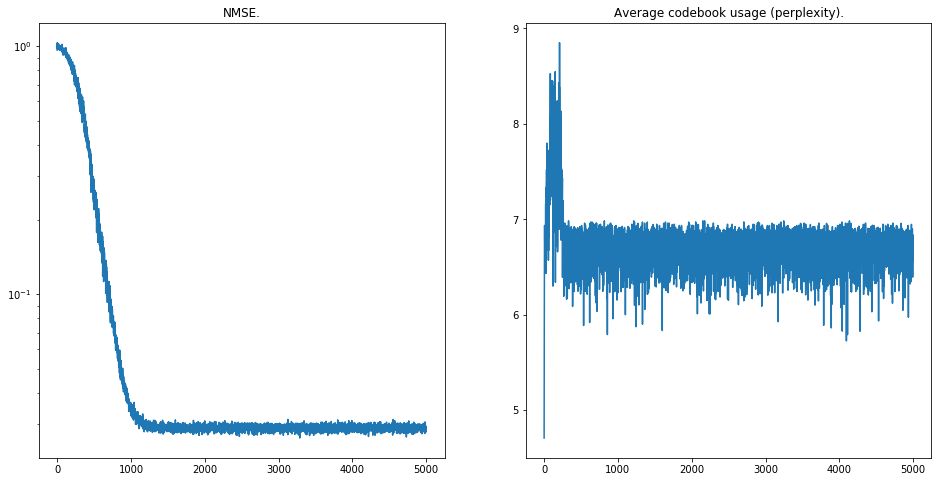

In [6]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')


# View latent space

In [0]:
# Latent space
z_, vq_output_eval_  = sess.run([z, vq_output_eval], feed_dict={x: X})

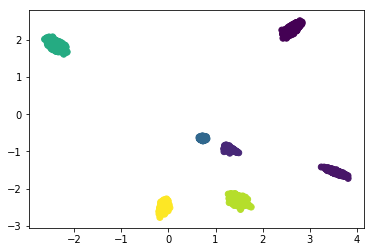

In [8]:
plt.scatter(z_[:,0], z_[:,1], c=vq_output_eval_['encoding_indices'])

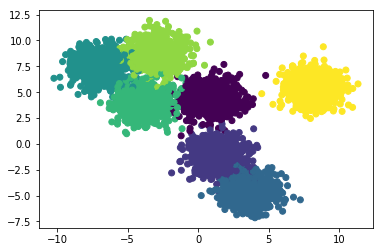

In [9]:
plt.scatter(X[:,0], X[:,1], c=y)

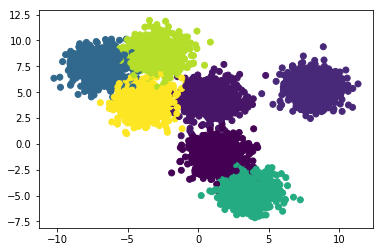

In [10]:
plt.scatter(X[:,0], X[:,1], c=vq_output_eval_['encoding_indices'])